In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits

In [39]:
# Model Opening
model_path = 'SIE+SHEAR'
model_ver = 'SIE_POS_SHEAR'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result

with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'SIE+SHEAR/SIE_POS_SHEAR', 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 0', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(2, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.30e+02, 20.81, 20.76, 0.107, 23.38, 0.0, 0.0)\n",
 "glafic.set_lens(2, 'pert', 0.261343256161012, 1.0, 20.90, 20.63, 0.1, 141.72, 0.0, 0.3)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 1, 1, 1, 1, 1, 0, 0)\n',
 'glafic.setopt_lens(2, 0, 0, 1, 1, 1, 1, 0, 1)\n',
 'glafic.setopt_point(1, 0, 1, 1)\n',
 '\n',
 '# model_init needs to be done again whe

In [40]:
# Extract the line containing 'glafic.startup_setnum('
startup_setnum_line = next(line for line in py if 'glafic.startup_setnum(' in line)

set_point_line = next(line for line in py if 'glafic.set_point(' in line)

# Extract the first number inside the parentheses
extracted_value = int(re.search(r'glafic\.startup_setnum\((\d+)', startup_setnum_line).group(1))

print(extracted_value)

set_point = int(re.search(r'glafic\.set_point\((\d+)', set_point_line).group(1))

print(set_point)

2
1


In [54]:
# Model Values 
# Find the line containing 'lens   sie' in opt_result
model_input = model_path.lower()
if model_input == 'nfw':
    model_input = 'anfw'
if model_input == 'c_sie':
    model_input = 'sie'

model_input = 'pert'

lens_sie_line = next(line for line in reversed(opt_result) if 'lens   ' + model_input in line)

print(lens_sie_line)

# Extract the values from the line
lens_sie_values = lens_sie_line.split()[2:]
lens_sie_values = [str(value) for value in lens_sie_values]
lens_sie_values

# Find the line containing 'glafic.set_point' in opt_result
set_point_line = next(line for line in reversed(opt_result) if 'point' in line)

print(set_point_line)

# Extract the values from the line
set_point_values = set_point_line.split()[1:]
set_point_values = [str(value) for value in set_point_values]
set_point_values


lens   pert    0.2613  1.000000e+00  2.089792e+01  2.063422e+01  2.418515e-02  1.403324e+02  0.000000e+00  2.730606e-01 

point  1.0000  2.084140e+01  2.073864e+01 



['1.0000', '2.084140e+01', '2.073864e+01']

In [55]:
x_cent = float(set_point_values[1])
y_cent = float(set_point_values[2])
print(x_cent, y_cent)

# Predicted Positions 
pred_columns = ['x', 'y', 'mag', 'err']
pred_file = model_path + '/' + model_ver + '_point.dat'
pred = pd.read_fwf(pred_file, sep=' ', header=None, skiprows=1, names=pred_columns)
pred['x_plot'] = (pred['x'] - 20) / 0.001
pred['y_plot'] = (pred['y'] - 20) / 0.001
pred

20.8414 20.73864


,x,y,mag,err,x_plot,y_plot
0,20.7777,20.3025,-16.6728,0.598,777.7,302.5
1,21.2731,20.9561,34.1253,0.000,1273.1,956.1
2,20.3909,21.0506,35.7335,0.021,390.9,1050.6
3,20.8198,21.2593,-49.7776,0.087,819.8,1259.3


In [56]:
# FITS File 
image = model_path + '/' + model_ver + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: SIE+SHEAR/SIE_POS_SHEAR_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [57]:
hdu_list[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 1560 / length of data axis 1                          
NAXIS2  =                 1560 / length of data axis 2                          
NAXIS3  =                    8 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'LINEAR  '                                                            
CTYPE2  = 'LINEAR  '                                                            
CRPIX1  =                    1                                                  
CRPIX2  =                   

In [58]:
# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)
kappa


array([[0.4260348 , 0.42614213, 0.42624956, ..., 0.4470895 , 0.44696447,
        0.44683957],
       [0.42612115, 0.42622864, 0.42633623, ..., 0.44719565, 0.4470704 ,
        0.44694522],
       [0.4262075 , 0.4263152 , 0.42642295, ..., 0.44730186, 0.44717637,
        0.44705096],
       ...,
       [0.43588838, 0.43600062, 0.43611294, ..., 0.43042818, 0.43032026,
        0.43021244],
       [0.4357982 , 0.43591025, 0.43602237, ..., 0.4303313 , 0.43022358,
        0.43011594],
       [0.43570805, 0.4358199 , 0.43593183, ..., 0.4302345 , 0.43012697,
        0.4300195 ]], dtype=float32)

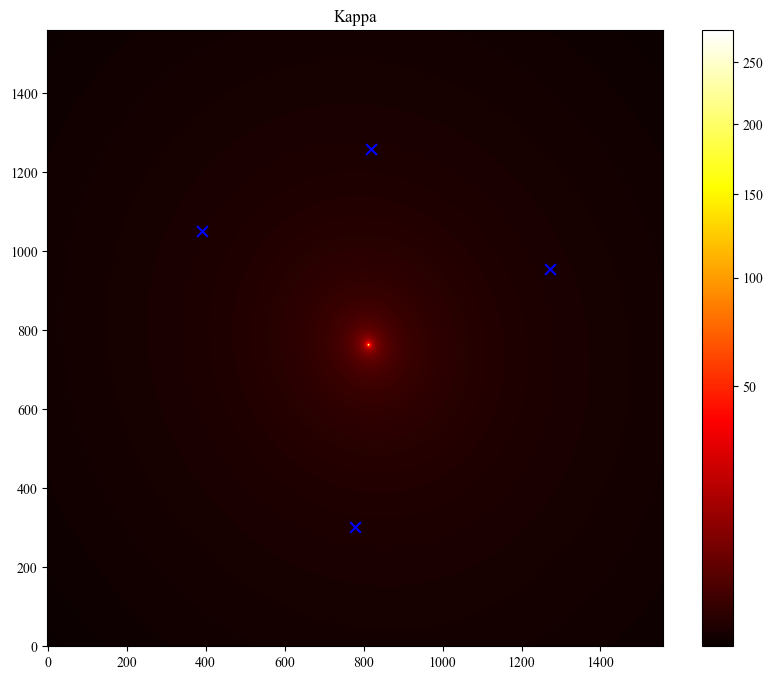

In [59]:
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(10, 8))
plt.imshow(kappa, cmap='hot', interpolation='nearest', norm=norm)
plt.gca().invert_yaxis()
plt.colorbar()
plt.scatter(pred['x_plot'], pred['y_plot'], c='blue', s=60, label='Predicted Positions', marker='x')
plt.title('Kappa')
plt.show()

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_6366/3728263333.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(


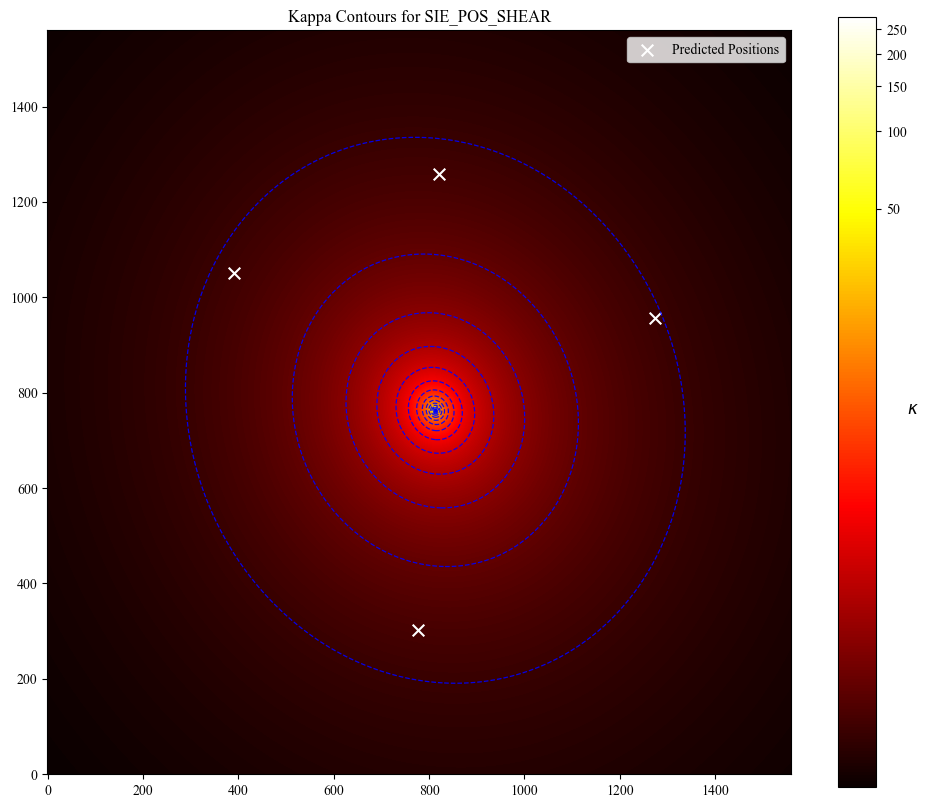

In [60]:
norm = ImageNormalize(kappa, stretch=LogStretch())
plt.figure(figsize=(12, 10))
plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
cbar = plt.colorbar(label=r'$\kappa$')
cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa.min() + 1e-6), np.log10(kappa.max()), 20)  # Add a small offset to avoid log(0)
plt.contour(
    kappa, 
    levels=levels, 
    colors='blue', 
    linewidths=0.9, 
    linestyles='dashed',
    alpha=0.9,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
    label='Kappa Contours'
)

plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.show()

Radial Kappa Value: 8.311564445495605


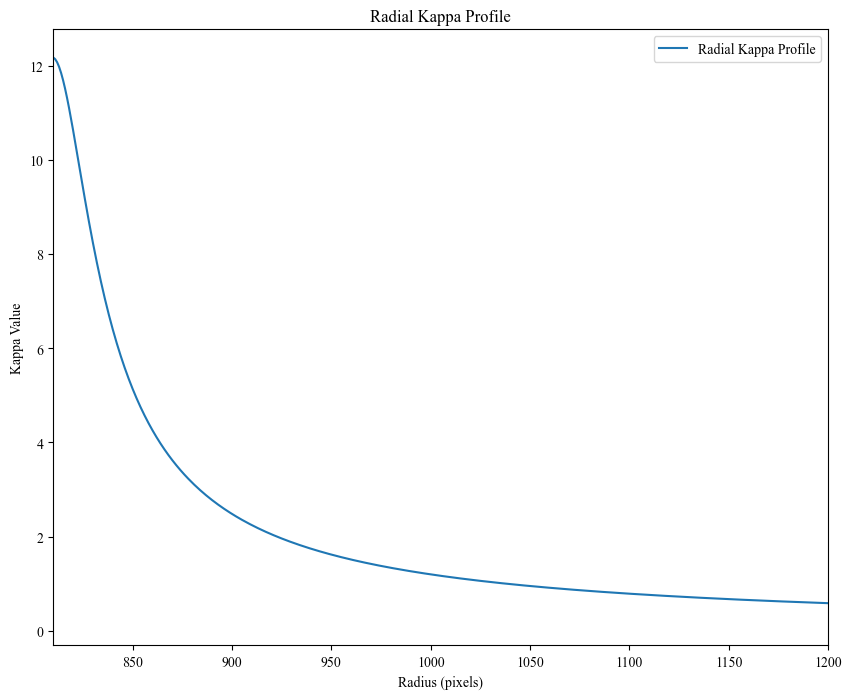

In [65]:
# Radial Kappa Plot
def radial_kappa(kappa, center, radius):
    """
    Calculate the radial kappa profile.
    
    Parameters:
        kappa (2D array): The kappa map.
        center (tuple): The center coordinates (x, y).
        radius (int): The radius for the radial profile.
        
    Returns:
        tuple: The radial distances and corresponding kappa values.
    """
    x_center, y_center = center
    y, x = np.indices(kappa.shape)
    r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the radius
    mask = (r <= radius)
    
    # Calculate the mean kappa within the radius
    radial_kappa = np.mean(kappa[mask])
    
    return radial_kappa

# Example usage
center = (kappa.shape[1] // 2, kappa.shape[0] // 2)  # Center of the image
radius = 50  # Radius for the radial profile
radial_kappa_value = radial_kappa(kappa, center, radius)
print(f"Radial Kappa Value: {radial_kappa_value}")


# Plot the radial kappa profile
plt.figure(figsize=(10, 8))
plt.plot(kappa[center[1], :], label='Radial Kappa Profile')
plt.xlabel('Radius (pixels)')
plt.ylabel('Kappa Value')
plt.title('Radial Kappa Profile')
plt.xlim(810, 1200)
plt.legend()
plt.show()


Text(0, 0.5, 'Y [arcsec]')

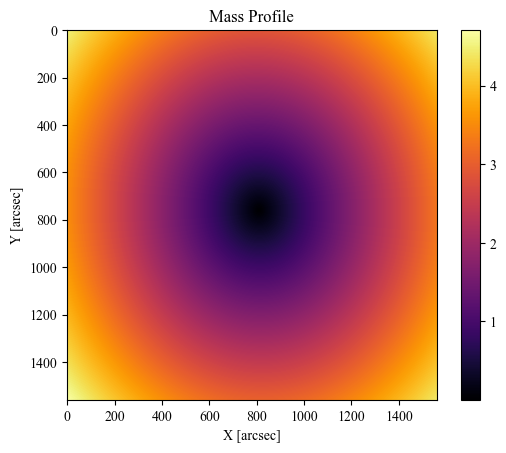

In [164]:
# Mass Profile 
plt.imshow(1/kappa, cmap='inferno')
plt.colorbar()
plt.title('Mass Profile')
plt.xlabel('X [arcsec]')
plt.ylabel('Y [arcsec]')